In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from tqdm import tqdm 

In [2]:
# load either catsndogs or tcga data set 
def load_data(tcga=True):
    if tcga: 
        file_path_data = "TCGAdata.txt"
        file_path_labels = "TCGAlabels.txt"
        delimiter=' '
    else:
        file_path_data = "CATSnDOGS.csv"
        file_path_labels = "Labels.csv"
        delimiter=',' 
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(file_path_labels, delimiter=delimiter, header=0, quotechar='"')
    return df_data.values, df_labels.values 

# find optimal number of features 
def feature_selection(data, labels, classifier):
    sel = VarianceThreshold(threshold=5.0)
    data_cleaned = sel.fit_transform(data)
    #X_test = sel.transform(X_test)

    max_features = min(100, data_cleaned.shape[1])
    feature_range = range(1, max_features + 1, 5)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    best_score = 0
    best_num_features = 0 
    best_features = None 
    best_data_feature_reduced = None 
    for n_features in feature_range:
        anova = SelectKBest(score_func=f_classif, k=n_features)
        data_feature_reduced = anova.fit_transform(data_cleaned, labels)
        cv_scores = cross_val_score(classifier, data_feature_reduced, labels, cv=kf)
        mean_cv_score = np.mean(cv_scores)
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_num_features = n_features
            # Get the mask of selected features
            best_features_mask = anova.get_support()
            # Get the names of the selected features
            best_features = np.where(best_features_mask == True)[0]  
            best_data_feature_reduced = data_feature_reduced
    #print(f"#features: {best_num_features}, score: {best_score}") 
    return best_features, best_num_features 


def standardize(train_data, test_data):
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)
    return train_data, test_data

def add_noise_to_matrix(matrix, noise_percent, tcga=True):
    total_data_points = matrix.size
    num_noisy_features = int((noise_percent / 100.0) * total_data_points)
    indices_to_noise = np.random.choice(total_data_points, num_noisy_features, replace=False)
    noisy_matrix = np.copy(matrix)
    noise_min = np.min(matrix)
    noise_max = np.max(matrix)
    
    if tcga:
        noise_values = np.random.uniform(noise_min, noise_max, size=num_noisy_features)
    else:
        noise_values = np.random.randint(noise_min, noise_max + 1, size=num_noisy_features)
    
    # Assign noise values to corresponding indices in noisy matrix
    chosen_indices = np.unravel_index(indices_to_noise, matrix.shape)
    noisy_matrix[chosen_indices] += noise_values
    
    return noisy_matrix

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [14:30<00:00, 87.09s/it]


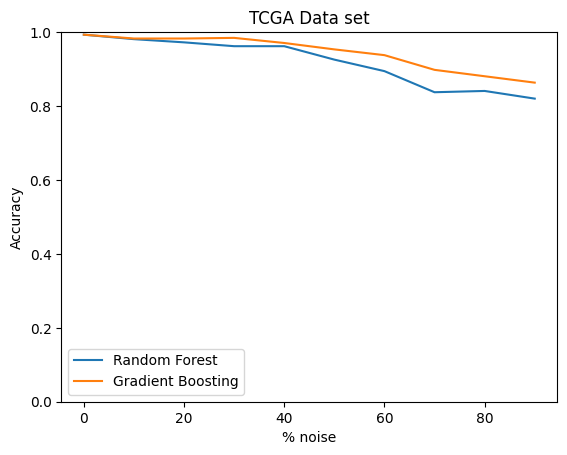

In [3]:
import warnings
warnings.filterwarnings('ignore')

accuracies_rf = []
accuracies_gb = []
noise_range = np.linspace(0, 90, 10)
classifier_rf = RandomForestClassifier(n_estimators=100)
classifier_gb = GradientBoostingClassifier(n_estimators=100)

feature_importance_rf = []
best_features_rf = []
feature_importance_gb = []
best_features_gb = []

for noise in tqdm(noise_range):
    data, labels = load_data()
    noisy_matrix = add_noise_to_matrix(data, noise)
    X_train, X_test, y_train, y_test = train_test_split(noisy_matrix, labels, test_size=0.2)

    #best_features, best_num_features = feature_selection(X_train, y_train.ravel(), classifier)
    anova = SelectKBest(score_func=f_classif, k=100)
    X_train_feature = anova.fit_transform(X_train, y_train.ravel())
    X_test_feature = anova.transform(X_test)
    best_features_mask = anova.get_support()
    best_features = np.where(best_features_mask == True)[0]  
    
    X_train_stand, X_test_stand = standardize(X_train_feature, X_test_feature)

    for classifier in [classifier_rf, classifier_gb]:
        classifier.fit(X_train_stand, y_train.ravel())
        y_pred_test = classifier.predict(X_test_stand)
        accuracy = accuracy_score(y_test, y_pred_test)

        feature_importances = classifier.feature_importances_
        sorted_indices = np.argsort(feature_importances)[::-1]
        sorted_feature_importance = feature_importances[sorted_indices]
        sorted_best_features = best_features[sorted_indices]

        if type(classifier) == type(classifier_rf):
            accuracies_rf.append(accuracy)
            feature_importance_rf.append(sorted_feature_importance)
            best_features_rf.append(sorted_best_features)
        else:
            accuracies_gb.append(accuracy)
            feature_importance_gb.append(sorted_feature_importance)
            best_features_gb.append(sorted_best_features)

plt.plot(noise_range, accuracies_rf, label="Random Forest")
plt.plot(noise_range, accuracies_gb, label="Gradient Boosting")
plt.title("TCGA Data set")
plt.xlabel("% noise")
plt.ylabel("Accuracy")
plt.legend()
plt.ylim([0,1])
plt.show()

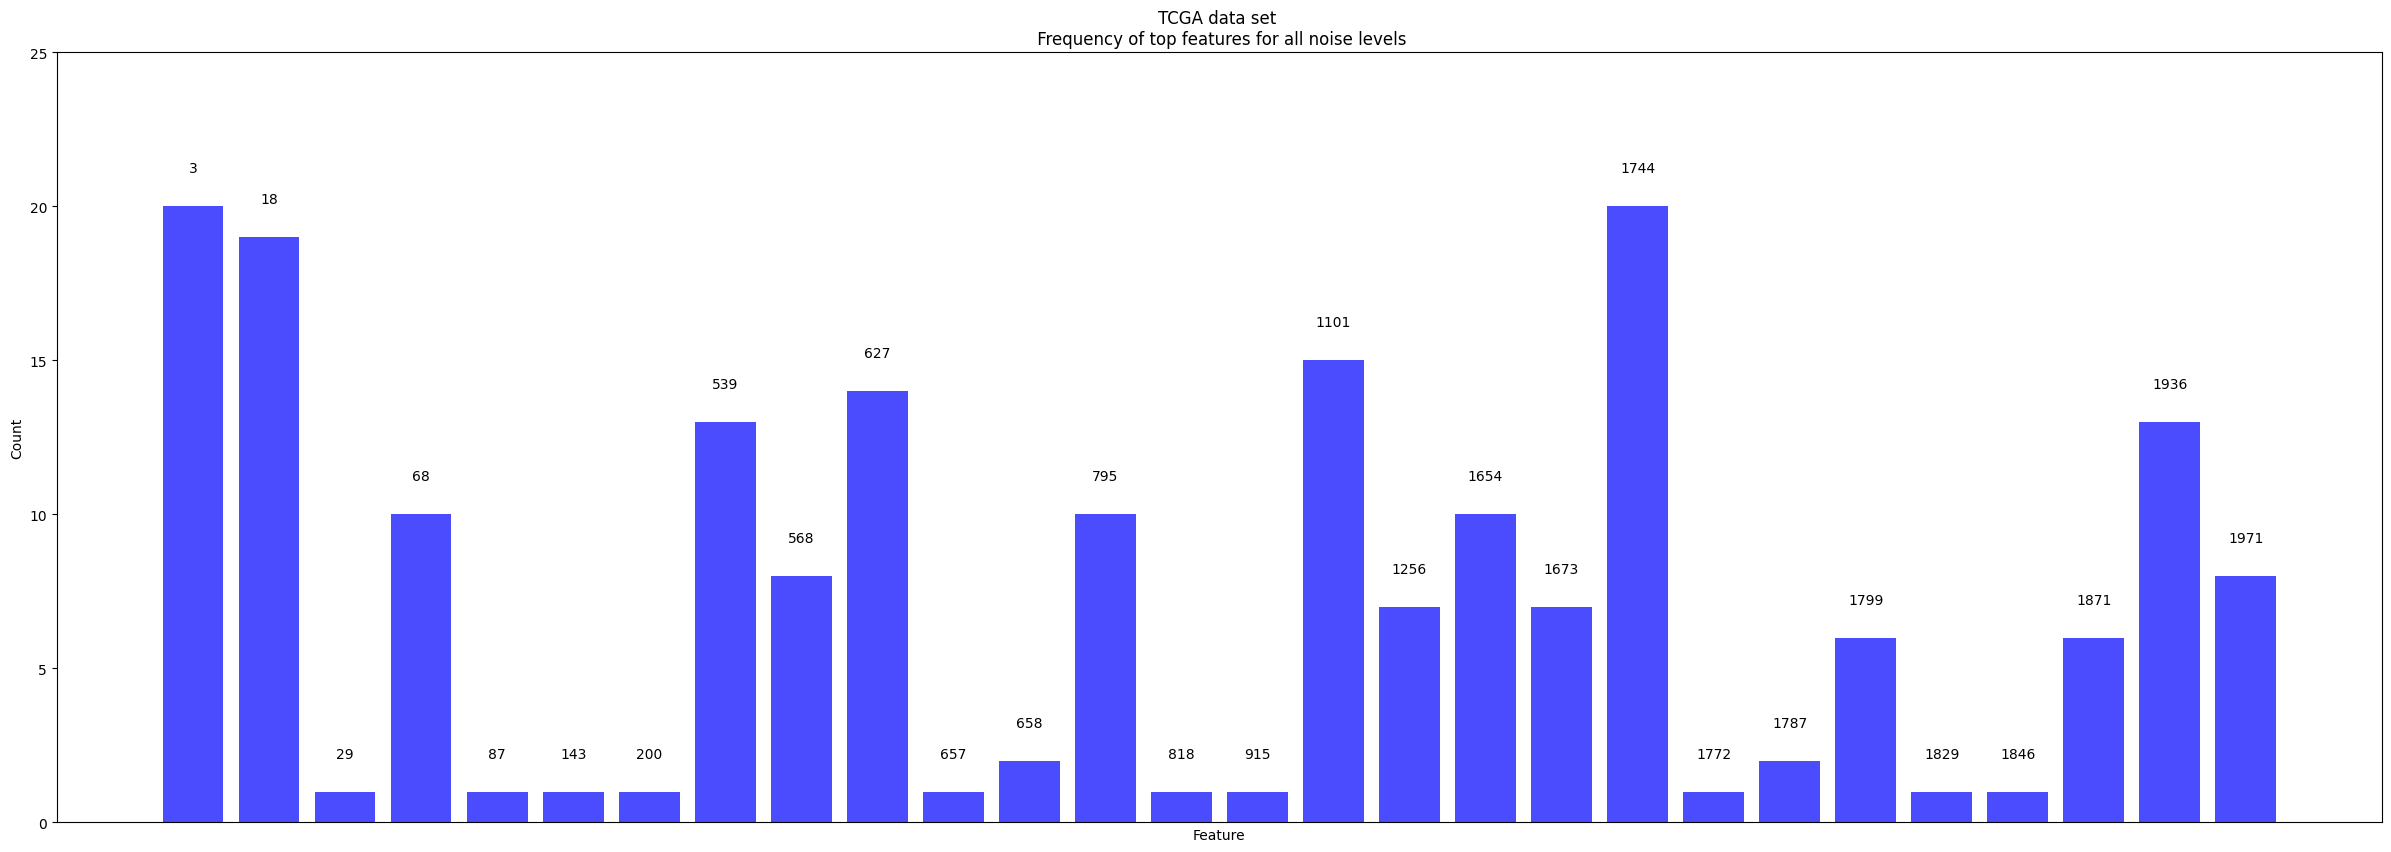

[   3   18   29   68   87  143  200  539  568  627  657  658  795  818
  915 1101 1256 1654 1673 1744 1772 1787 1799 1829 1846 1871 1936 1971]


In [10]:
# Inspect what features are most important for each classifier 

overall = np.zeros(data.shape[1])
matches = []
for i, noise in enumerate(noise_range):
    overall[best_features_rf[i][:10]] += 1 
    overall[best_features_gb[i][:10]] += 1 
    common_values = np.intersect1d(best_features_rf[i][:10], best_features_gb[i][:10], return_indices=False)
    #print(f"Common features for noise {round(noise, 1)}: {common_values[:10]}")
    matches.append(len(common_values))

#plt.plot(noise_range, matches)
#plt.xlabel("% noise")
#plt.ylabel("number of matches")
#plt.show()     

last_non_zero_idx = len(overall) - np.argmax(overall[::-1] != 0) - 1
overall = overall[:last_non_zero_idx + 1]

count = overall[overall >= 1]
features = np.where(overall >= 1)[0] 
plt.figure(figsize=(30,10))
bars = plt.bar(np.arange(1, len(count)+1), count, color='blue', alpha=0.7)
for bar, value in zip(bars, features):
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width() / 2,  # X coordinate for text (center of the bar)
            yval + 1,  # Y coordinate for text (slightly above the bar)
            value + 1,  # feature name is +1 because features is actually feature index 
            ha='center', va='bottom', fontsize=10, color='black')
plt.title("TCGA data set \n Frequency of top features for all noise levels")
plt.xlabel("Feature")
plt.ylabel("Count")  
plt.ylim([0, 25])
plt.xticks([])
plt.show()
print(features + 1)


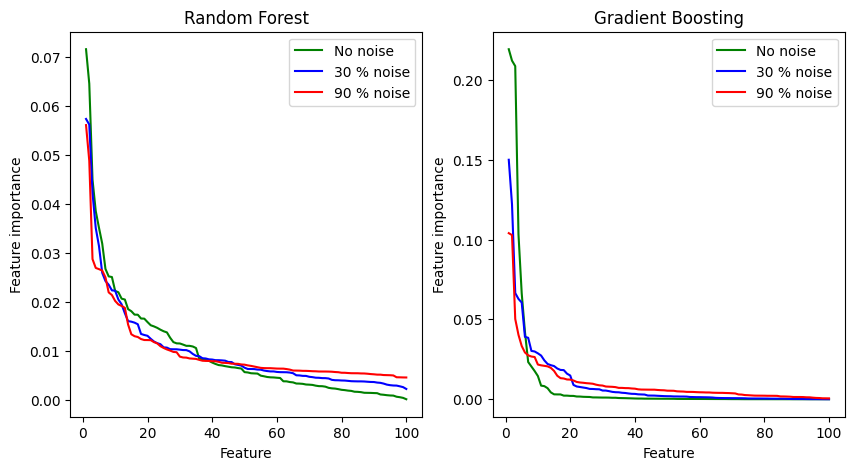

In [5]:
# Inspect feature importance 

#for i, noise in enumerate(noise_range):
    #print(f"Noise {noise}")
    #print(f"Gradient Boosting: Max: {np.max(feature_importance_gb[i])}, Mean: {np.mean(feature_importance_gb[i])}, Var: {np.var(feature_importance_gb[i])}, Significant Components: {len(np.where(feature_importance_gb[i] > 2*np.std(feature_importance_gb[i]))[0])}")
    #print(f"Random Forest: Max: {np.max(feature_importance_rf[i])}, Mean: {np.mean(feature_importance_rf[i])}, Var: {np.var(feature_importance_rf[i])}, Significant Components: {len(np.where(feature_importance_rf[i] > 2*np.std(feature_importance_rf[i]))[0])}")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Random Forest")
plt.plot(np.arange(1, len(feature_importance_rf[0])+1), feature_importance_rf[0], 'g', label='No noise')
plt.plot(np.arange(1, len(feature_importance_rf[3])+1), feature_importance_rf[3], 'b', label='30 % noise')
plt.plot(np.arange(1, len(feature_importance_rf[-1])+1), feature_importance_rf[-1], 'r', label='90 % noise')
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.legend()
plt.subplot(1,2,2)
plt.title("Gradient Boosting")
plt.plot(np.arange(1, len(feature_importance_gb[0])+1), feature_importance_gb[0], 'g', label='No noise')
plt.plot(np.arange(1, len(feature_importance_gb[3])+1), feature_importance_gb[3], 'b', label='30 % noise')
plt.plot(np.arange(1, len(feature_importance_gb[-1])+1), feature_importance_gb[-1], 'r', label='90 % noise')
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.legend()
plt.show()

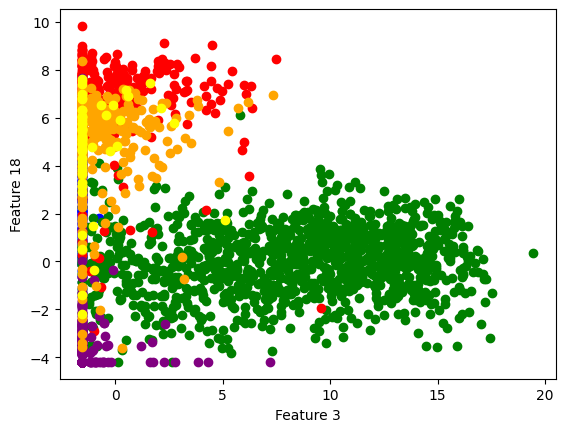

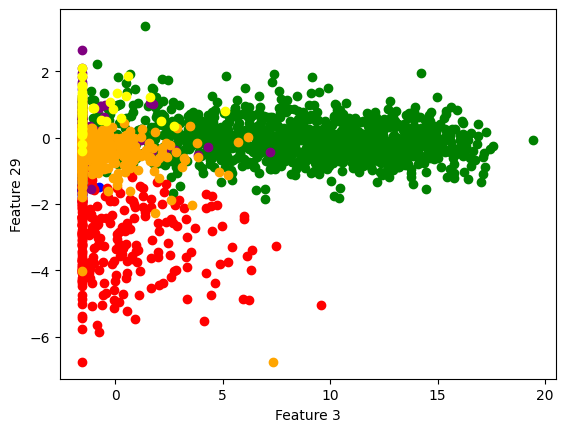

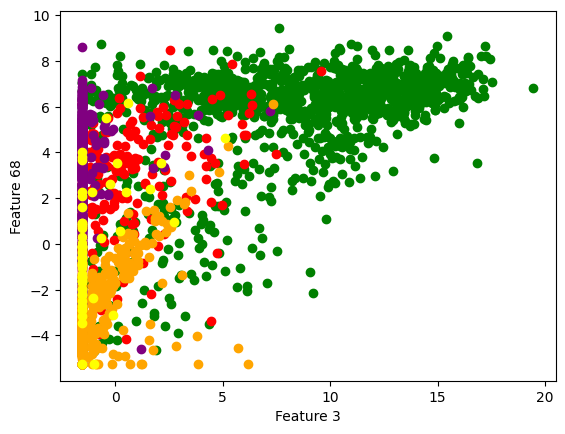

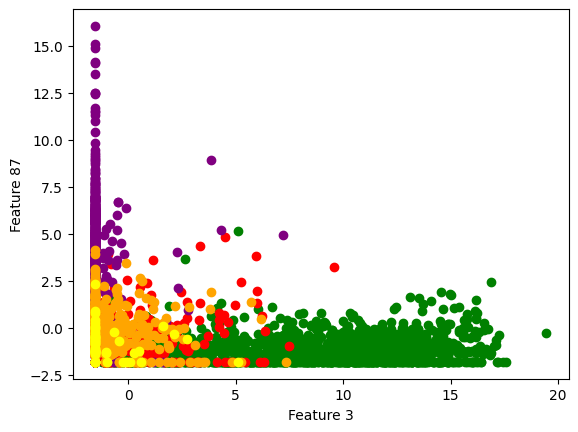

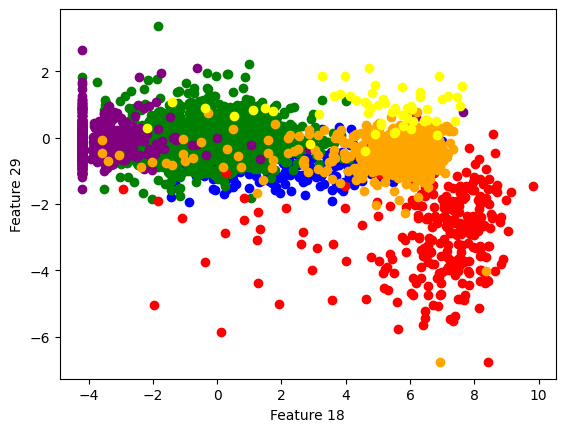

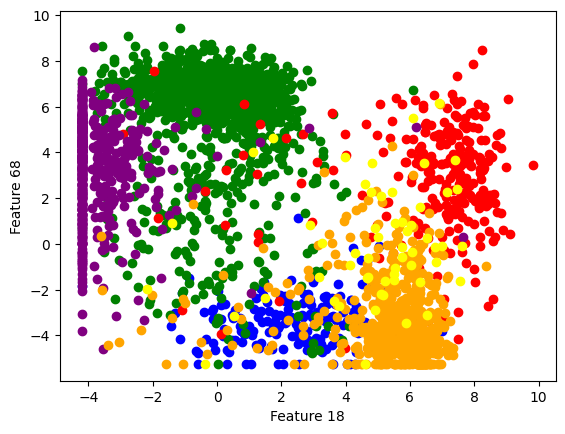

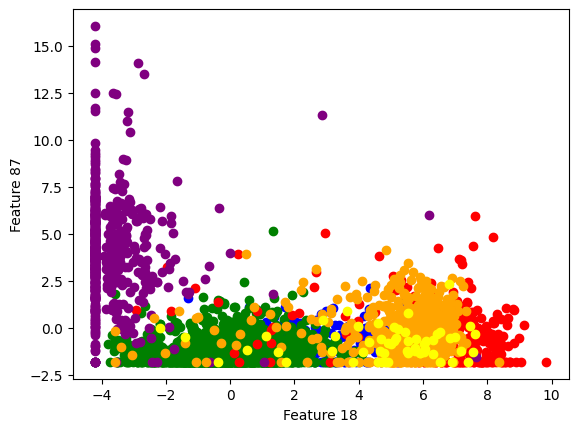

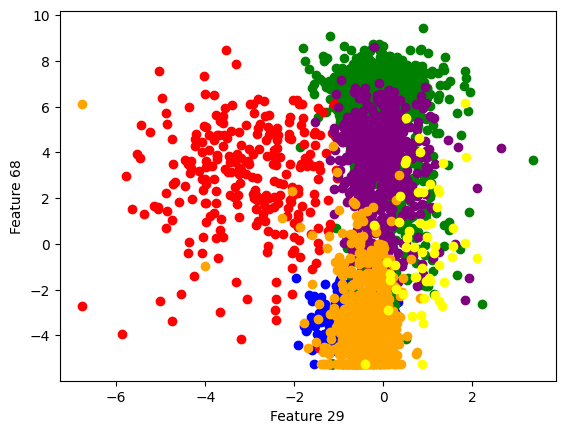

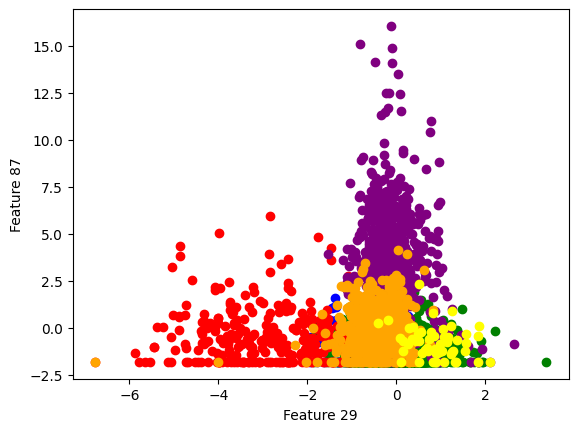

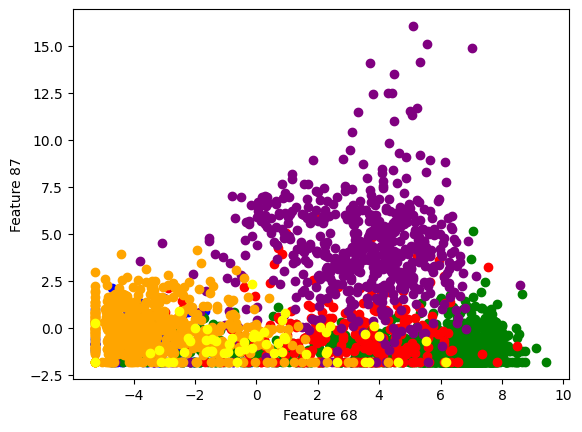

In [6]:
# plotting important features 
import itertools

data, labels = load_data()
plot_features = True 
if plot_features:
    label_colors = {
        'GBM': 'blue',
        'BC': 'green',
        'OV': 'red',
        'LU': 'purple',
        'KI': 'orange',
        'U': 'yellow'
    }

    
    for feature1, feature2 in itertools.combinations(features[:5], 2):
        x = data[:, feature1]
        y = data[:, feature2]
        
        for label, color in label_colors.items():
            mask = np.where(labels==label)[0]
            plt.scatter(x[mask], y[mask], color=color, label=label)
        
        plt.xlabel(f"Feature {feature1 + 1}")
        plt.ylabel(f"Feature {feature2 + 1}")
        plt.show()

In [7]:
best_features

array([   2,   15,   17,   29,   62,   67,   71,  127,  177,  192,  199,
        216,  288,  307,  349,  374,  391,  393,  417,  429,  461,  474,
        506,  538,  540,  543,  554,  567,  578,  595,  599,  626,  645,
        656,  657,  662,  672,  675,  686,  794,  802,  825,  842,  854,
        870,  892,  914,  924,  939,  981, 1002, 1027, 1032, 1065, 1088,
       1096, 1097, 1100, 1127, 1149, 1172, 1202, 1205, 1217, 1233, 1255,
       1262, 1283, 1299, 1374, 1398, 1431, 1442, 1516, 1520, 1548, 1550,
       1579, 1603, 1643, 1653, 1656, 1660, 1672, 1678, 1693, 1696, 1712,
       1743, 1771, 1786, 1798, 1811, 1828, 1845, 1881, 1883, 1930, 1935,
       1970], dtype=int64)